In [2]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import *
import random
import matplotlib.pyplot as plt


In [21]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error

# 설정
data = ['coin']
model_name = 'trTFMLP'
num = 100  # Model k per loss
np.random.seed(100)

bolt_all_data = []
performance_lst = []

for d in range(len(data)):
    # 데이터 로드
    target_X = pd.read_csv(f"../data/{data[d]}/train_input_7.csv").iloc[:,1:].values.astype(np.float32)
    target_y = pd.read_csv(f"../data/{data[d]}/train_output_7.csv").iloc[:,1:].values.astype(np.float32)
    
    target_X_val = target_X[-round(target_X.shape[0]*0.2):,:]
    target_y_val = target_y[-round(target_y.shape[0]*0.2):]
    target_X = target_X[:-round(target_X.shape[0]*0.2),:]
    target_y = target_y[:-round(target_y.shape[0]*0.2)]

    test_X = pd.read_csv(f"../data/{data[d]}/val_input_7.csv").iloc[:,1:].values.astype(np.float32)
    test_y = pd.read_csv(f"../data/{data[d]}/val_output_7.csv").iloc[:,1:].values.astype(np.float32)

    # 결과 파일 불러오기
    folder_path = 'resulttf/test/'
    folder_path2 = 'resulttf/val/'
    all_files = os.listdir(folder_path)
    all_files2 = os.listdir(folder_path2)
    
    files = sorted([f for f in all_files if f.startswith(f"{model_name}_{data[d]}") and f.endswith("pred.csv")])
    files2 = sorted([f for f in all_files2 if f.startswith(f"{model_name}_{data[d]}") and f.endswith("pred.csv")])
    dataframes = [pd.read_csv(os.path.join(folder_path, f)) for f in files]
    dataframes2 = [pd.read_csv(os.path.join(folder_path2, f)) for f in files2]

    all = np.array([np.stack(df.iloc[:,1:].values.reshape(num,-1,target_y.shape[1])) for df in dataframes])
    all_val = np.array([np.stack(df.iloc[:,1:].values.reshape(num,-1,target_y.shape[1])) for df in dataframes2])

    # 평가 루프
    p = 10
    b = 30
    all_ens_mae_lst = []
    bolt_mae_lst = []
    inv_mae_lst = []
    mean_mae_lst = []

    for i in range(b):
        nums = [np.random.choice(num, size=p, replace=False) for _ in range(5)]

        score = np.concatenate([all[j][nums[j]] for j in range(5)], axis=0)
        all_ens = np.median(score, axis=0).flatten()
        all_ens_mae = mean_absolute_error(test_y.flatten(), all_ens)
        all_ens_mae_lst.append(all_ens_mae)

        mean_mae = np.mean(score, axis=0).flatten()
        all_mean_mae = mean_absolute_error(test_y.flatten(), mean_mae)
        mean_mae_lst.append(all_mean_mae)

        # 각 지표별 예측
        val_preds = [np.median(np.nan_to_num(all_val[j][nums[j]], nan=0), axis=0).flatten() for j in range(5)]
        perf_maes = [mean_absolute_error(target_y_val.flatten(), pred) for pred in val_preds]

        fin_preds = [np.median(np.nan_to_num(all[j][nums[j]], nan=0), axis=0).flatten() for j in range(5)]
        performance = np.array(perf_maes)
        performance_lst.append(performance)

        bolt = []
        bolt_mae_lst_ = []
        # for beta in np.arange(1, 10.2, 0.2):
        # for beta in np.arange(1, 2):
        # for beta in np.arange(3, 4):
        for beta in np.arange(5, 6):
        # beta = 1 # 조정 파라미터
            weights = np.exp(-beta * performance)
            normalized_weights = weights / np.sum(weights)
            gd = np.stack(fin_preds, axis=0)
            ensemble_prediction = np.dot(normalized_weights, gd)
            bolt.append(ensemble_prediction)
            bolt_mae = mean_absolute_error(test_y.flatten(), ensemble_prediction.flatten())
            bolt_mae_lst_.append(bolt_mae)
        bolt_mae_lst.append(bolt_mae_lst_)

        inv_weights = 1.0 / performance
        inv_weights /= np.sum(inv_weights)
        ens_pred_inv = np.dot(inv_weights, gd)
        inv_mae = mean_absolute_error(test_y.flatten(), ens_pred_inv.flatten())
        inv_mae_lst.append(inv_mae)

    bolt_all_data.append(bolt_mae_lst)
    a = np.min(np.array(bolt_mae_lst), axis=0)
    summary = pd.DataFrame({
        'BOLT': np.min(np.array(bolt_mae_lst), axis=1),
        'Median': all_ens_mae_lst,
        'INV': inv_mae_lst,
        'Mean': mean_mae_lst
    })
    summary.to_csv(f'{model_name}_{data[d]}_summary_mae.csv')
    print(f'{data[d]} 완료')



coin 완료


In [22]:
rec = []
#data = ['TEM','SOL', 'WID', 'AIR', 'MET', 'COIN']
for i in range(len(data)):
    d= pd.read_csv(f'{model_name}_{data[i]}_summary_mae.csv').iloc[:,1:].describe().T.iloc[:,1:3].round(5)
    d['mean(std)'] = d.apply(
    lambda r: f"{r['mean']:.5f} ({r['std']:.5f})", axis=1)
    
    rec.append(d.loc[:,'mean(std)'])

dfff = pd.DataFrame(rec).T

dfff.columns = data
dfff.to_csv(f'{model_name}_result_ensemble_mae.csv')


dfff

,coin
BOLT,1.36849 (0.00332)
Median,1.39167 (0.00441)
INV,1.43583 (0.00499)
Mean,1.58375 (0.03159)


In [ ]:
pd.DataFrame(np.array(performance_lst)).to_csv(f'perfomnace_val_{model_name}_mae.csv')

In [44]:
n1  = [1,3,5]
b135 = [] 
for j in range(1):
    a = np.array([np.array(bolt_all_data)[j].mean(axis=0)[np.where(np.arange(0.05,10.05,0.05) == n1[i])] for i in range(3)])
    b135.append(a)

df135 = pd.DataFrame(np.array(b135).reshape(1,3)).T
df135.columns = data
df135.T.round(3)

,0,1,2
coin,36.666,36.691,36.719


In [46]:
from scipy.stats import anderson

result = anderson(residuals, dist='norm')
print("Anderson-Darling test statistic:", result.statistic)
for cv, sig in zip(result.critical_values, result.significance_level):
    print(f"Significance level {sig}%: critical value = {cv}")

Anderson-Darling test statistic: 98.48700669338905
Significance level 15.0%: critical value = 0.576
Significance level 10.0%: critical value = 0.656
Significance level 5.0%: critical value = 0.787
Significance level 2.5%: critical value = 0.918
Significance level 1.0%: critical value = 1.091


(array([   6.,   10.,    4.,   10.,   26.,   72.,  131.,  219.,  341.,
         795., 1627., 2182., 1774.,  885.,  350.,  107.,   32.,   12.,
           6.,    3.]),
 array([-16.90038611, -15.41528472, -13.93018334, -12.44508195,
        -10.95998056,  -9.47487918,  -7.98977779,  -6.5046764 ,
         -5.01957502,  -3.53447363,  -2.04937225,  -0.56427086,
          0.92083053,   2.40593191,   3.8910333 ,   5.37613469,
          6.86123607,   8.34633746,   9.83143885,  11.31654023,
         12.80164162]),
 <BarContainer object of 20 artists>)

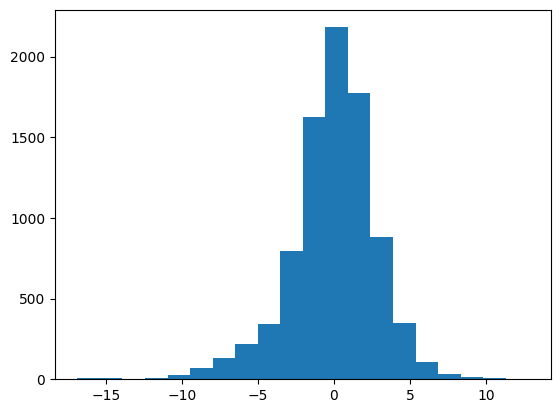

In [36]:
plt.hist(test_y.flatten() -(all[0][0]).flatten(), bins =20) #.shape